In [1]:
import dlib, cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects

In [2]:
# dlib 모델 설정
detector = dlib.get_frontal_face_detector()
sp = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
facerec = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

RuntimeError: Unable to open models/shape_predictor_68_face_landmarks.dat

In [4]:
# 얼굴을 찾는 함수
def find_faces(img):
    # dets에 얼굴 찾은 결과물이 들어간다. detector 사용
    dets = detector(img, 1)
    
    # 얼굴을 못찾으면 빈 배열을 리턴한다.
    if len(dets) == 0:
        return np.empty(0), np.empty(0), np.empty(0)
    
    rects, shapes = [], []
    shapes_np = np.zeros((len(dets), 68, 2), dtype=np.int)
    
    # 얼굴의 개수만큼 for문을 돌린다.
    for k,d in enumerate(dets):
        rect = ((d.left(), d.top()), (d.right(), d.bottom()))
        rects.append(rect)
        
        shape = sp(img, d)
        
        for i in range(0, 68):
            shapes_np[k][i] = (shape.part(i).x, shape.part(i).y)
        
        shapes.append(shape)
    
    return rects, shapes, shapes_np    

In [5]:
# 얼굴을 인코드 하는 함수
def encode_faces(img, shapes):
    face_descriptors = []
    # shapes : 랜드마크들의 집합
    for shape in shapes:
        face_descriptor = facerec.compute_face_descriptor(img, shape)
        face_descriptors.append(np.array(face_descriptor))
        
    return np.array(face_descriptors)

In [7]:
img_paths = {'iu':'img/iu.jpg'}
descs = {'iu':None}

# IU의 얼굴 특징을 여러개의 np.array로 특징을 잡아낸다.
for name, img_path in img_paths.items():
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    _, img_shapes, _ = find_faces(img_rgb)
    descs[name] = encode_faces(img_rgb, img_shapes)[0]

np.save('img/descs.npy', descs)
print(descs)

{'iu': array([-0.07160944,  0.05722571,  0.09105828, -0.09825656, -0.1342593 ,
       -0.05152601, -0.10219713, -0.12624876,  0.09686158, -0.1915191 ,
        0.1847658 , -0.1011694 , -0.22470592, -0.03581882, -0.05638627,
        0.23523831, -0.16642235, -0.13725269, -0.06023238,  0.00192366,
        0.05892999,  0.05149231,  0.01275153,  0.01863787, -0.11709225,
       -0.32803059, -0.1108074 , -0.02509987, -0.09778684, -0.06019295,
       -0.07701736,  0.02411536, -0.16906771,  0.01835991,  0.02892482,
        0.13026088, -0.00289939, -0.09100738,  0.11825142,  0.0252841 ,
       -0.30853674,  0.02707814,  0.10185716,  0.19219555,  0.17048082,
       -0.03005134, -0.0018438 , -0.12557501,  0.13420305, -0.18623435,
       -0.02009945,  0.11708294,  0.04401523,  0.04961842,  0.03808007,
       -0.0801222 ,  0.03394612,  0.17753193, -0.09444014,  0.00837443,
        0.12545913, -0.09146658, -0.01988176, -0.10915765,  0.19631279,
        0.07947227, -0.14300528, -0.20105362,  0.08296861

In [8]:
img_bgr = cv2.imread('img/iuval.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

rects, shapes, _ = find_faces(img_rgb)
descriptors = encode_faces(img_rgb, shapes)

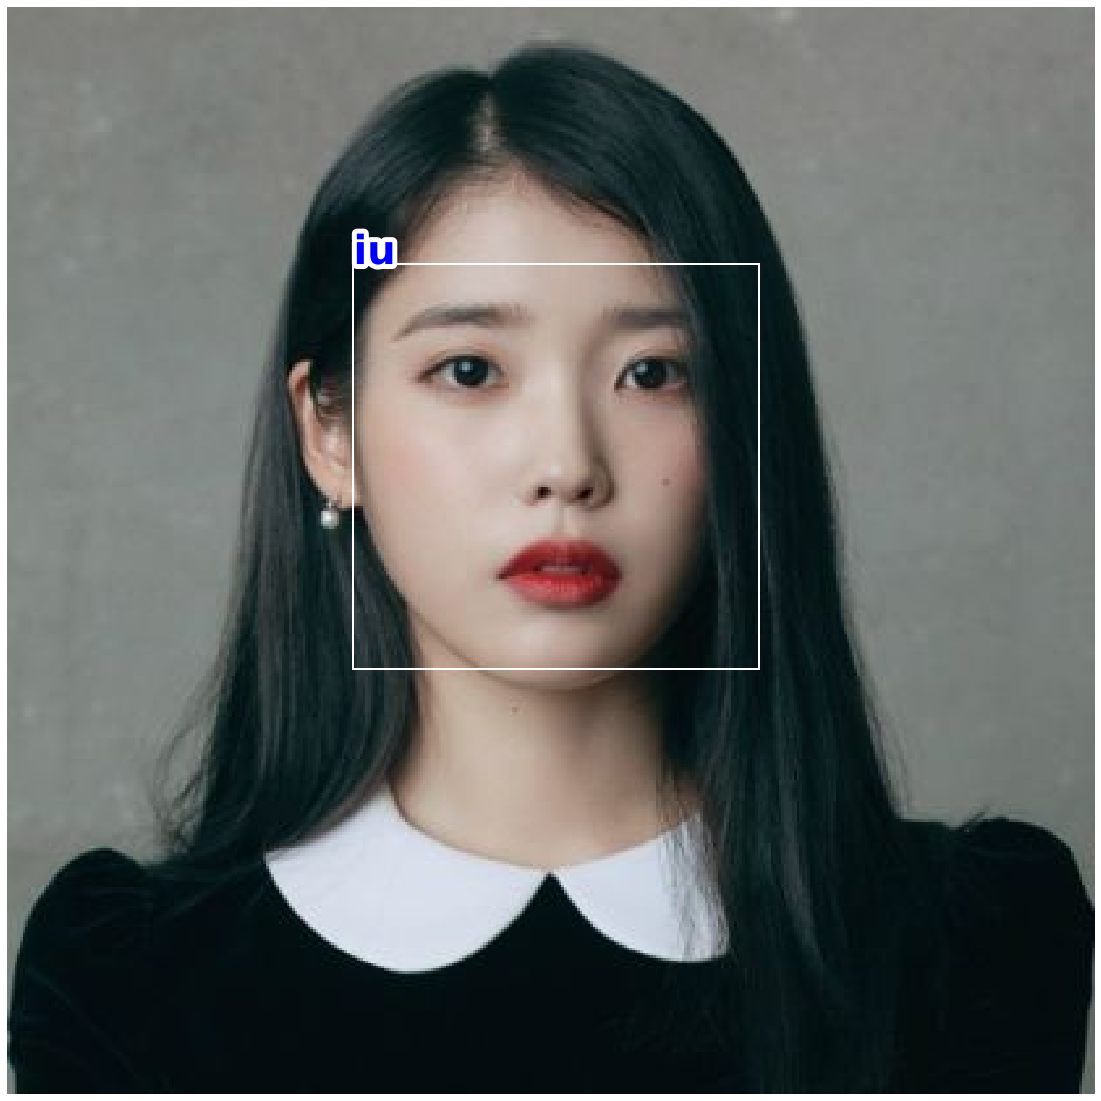

In [10]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.imshow(img_rgb)

for i, desc in enumerate(descriptors):
    
    found = False
    for name, saved_desc in descs.items():
        # dist : 유클리디안 거리
        dist = np.linalg.norm([desc] - saved_desc, axis=1)

        if dist < 0.6:
            found = True

            text = ax.text(rects[i][0][0], rects[i][0][1], name,
                    color='b', fontsize=40, fontweight='bold')
            text.set_path_effects([path_effects.Stroke(linewidth=10, foreground='white'), path_effects.Normal()])
            rect = patches.Rectangle(rects[i][0],
                                 rects[i][1][1] - rects[i][0][1],
                                 rects[i][1][0] - rects[i][0][0],
                                 linewidth=2, edgecolor='w', facecolor='none')
            ax.add_patch(rect)

            break
    
    if not found:
        ax.text(rects[i][0][0], rects[i][0][1], 'unknown',
                color='r', fontsize=20, fontweight='bold')
        rect = patches.Rectangle(rects[i][0],
                             rects[i][1][1] - rects[i][0][1],
                             rects[i][1][0] - rects[i][0][0],
                             linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

plt.axis('off')
plt.savefig('result/output.png')
plt.show()